In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/kaggle-train/kaggle_test.csv
/kaggle/input/kaggle-train/kaggle_train.csv


In [2]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
import json
import math
import os
from sklearn import tree
import warnings
warnings.filterwarnings("ignore")
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from xgboost.sklearn import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import RandomizedSearchCV

In [3]:
from sklearn.model_selection import validation_curve
from sklearn.pipeline import make_pipeline
from sklearn.metrics import make_scorer

In [4]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

#### Read the data

In [5]:
test = pd.read_csv('/kaggle/input/kaggle-train/kaggle_test.csv',sep=",", na_values=["?",",","#","NaN","unknown",""])
train=pd.read_csv('/kaggle/input/kaggle-train/kaggle_train.csv', sep=",", na_values=["?",",","#","NaN","unknown",""])

In [6]:
train.head()

,year,month,day,medicine,sales,discounted,year_month,city_medicine,week,footfall_perday_permed,old_new,latitude,longitude,weekday,dayofweek
0,2017,1,2,1,28.0,1,2017_01,1_1,1,0.341523,old,22.545412,88.356775,0,0
1,2017,1,2,2,72.0,0,2017_01,1_2,1,0.878203,old,22.545412,88.356775,0,0
2,2017,1,2,3,128.0,0,2017_01,1_3,1,1.561250,old,22.545412,88.356775,0,0
3,2017,1,2,4,20.0,0,2017_01,1_4,1,0.243945,old,22.545412,88.356775,0,0
4,2017,1,2,5,4.0,0,2017_01,1_5,1,0.048789,old,22.545412,88.356775,0,0


In [7]:
test.head()

,year,month,day,medicine,discounted,year_month,city_medicine,week,old_new,latitude,longitude,weekday,dayofweek
0,2018,7,1,1292,0,2018_07,1_1292,26,old,22.545412,88.356775,1,6
1,2018,7,1,1,0,2018_07,1_1,26,old,22.545412,88.356775,1,6
2,2018,7,1,2,1,2018_07,1_2,26,old,22.545412,88.356775,1,6
3,2018,7,1,3,0,2018_07,1_3,26,old,22.545412,88.356775,1,6
4,2018,7,1,4,0,2018_07,1_4,26,old,22.545412,88.356775,1,6


##### converting the required columns to category type as it saves memory

In [8]:
catcols=["city_medicine","year_month","medicine","longitude","latitude","year","month","day","week","old_new"]
for col in catcols:
    train[col]=train[col].astype("category")
    test[col]=test[col].astype("category")

In [9]:
for col in ["discounted", "weekday", "dayofweek"]:# converted to int as xgboost model is giving errors
    train[col]=train[col].astype("int")
    test[col]=test[col].astype("int")

In [10]:
train.dtypes

year                      category
month                     category
day                       category
medicine                  category
sales                      float64
discounted                   int64
year_month                category
city_medicine             category
week                      category
footfall_perday_permed     float64
old_new                   category
latitude                  category
longitude                 category
weekday                      int64
dayofweek                    int64
dtype: object

In [11]:
X=train.drop(["sales","footfall_perday_permed"],axis=1)
y=train["footfall_perday_permed"]

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.06,random_state=123,shuffle=False) # train test split

In [13]:
X_train.tail(2)

,year,month,day,medicine,discounted,year_month,city_medicine,week,old_new,latitude,longitude,weekday,dayofweek
11016255,2018,6,1,1777,0,2018_06,9_1777,22,old,23.021624,72.579707,0,4
11016256,2018,6,1,1778,0,2018_06,9_1778,22,old,23.021624,72.579707,0,4


####  Using Target encoding& label encoding  approach as there is high cardinality in data  we end up getting many columns if we go with one hot encoding

In [14]:
from category_encoders import TargetEncoder 
tarcols=["city_medicine","year_month","medicine","longitude","latitude"]
encoder = TargetEncoder()
encoder.fit(X_train[tarcols], y_train)
X_train[tarcols]=encoder.transform(X_train[tarcols])
X_test[tarcols]=encoder.transform(X_test[tarcols])
test[tarcols]=encoder.transform(test[tarcols])

In [15]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
lecols=["year","month","day","week","old_new"]

for col in lecols:
    le.fit(X_train[col])
    X_train[col]=le.transform(X_train[col])
    X_test[col]=le.transform(X_test[col])
    test[col]=le.transform(test[col])
    

### Build  linear regression

In [16]:
from sklearn.linear_model import LinearRegression
reg= LinearRegression()
reg = reg.fit(X_train, y_train)
train_pred = reg.predict(X_train)
test_pred = reg.predict(X_test)

In [17]:
print("RMSE OF LINEAR REGRESSION=",np.sqrt(mean_squared_error(y_train, train_pred)))
print("MAPE OF LINEAR REGRESSION=",mean_absolute_percentage_error(y_train,train_pred))

RMSE OF LINEAR REGRESSION= 0.8466680305614882
MAPE OF LINEAR REGRESSION= 96.99542568643793


In [18]:
print("RMSE OF LINEAR REGRESSION=",np.sqrt(mean_squared_error(y_test, test_pred)))
print("MAPE OF LINEAR REGRESSION=",mean_absolute_percentage_error(y_test,test_pred))

RMSE OF LINEAR REGRESSION= 0.7009841868205181
MAPE OF LINEAR REGRESSION= 99.60300342763374


In [19]:
reg.predict(test)

array([0.26624826, 0.22078277, 1.24659563, ..., 0.19636042, 0.39443245,
       0.3690044 ])

In [20]:
xgb=XGBRegressor(random_state=1234)
xgb.fit(X_train, y_train)
train_pred = xgb.predict(X_train)

[13:02:02] WARNING: ../src/gbm/gbtree.cc:139: Tree method is automatically selected to be 'approx' for faster speed. To use old behavior (exact greedy algorithm on single machine), set tree_method to 'exact'.


In [21]:
test_pred = xgb.predict(X_test)
xgb.predict(test)

array([0.28892863, 0.25643733, 1.197406  , ..., 0.14364278, 0.36963123,
       0.34621066], dtype=float32)

In [22]:
print("RMSE OF XGB REGRESSION=",np.sqrt(mean_squared_error(y_train, train_pred)))
print("MAPE OF XGB REGRESSION=",mean_absolute_percentage_error(y_train,train_pred))

RMSE OF XGB REGRESSION= 0.8942860272781777
MAPE OF XGB REGRESSION= 78.41816397146474


In [23]:
print("RMSE OF XGB REGRESSION=",np.sqrt(mean_squared_error(y_test, test_pred)))
print("MAPE OF XGB REGRESSION=",mean_absolute_percentage_error(y_test,test_pred))

RMSE OF XGB REGRESSION= 0.7983437033631
MAPE OF XGB REGRESSION= 92.78183756431567


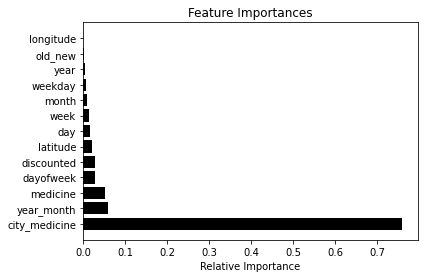

In [24]:
from matplotlib import pyplot as plt
features = X_train.columns
importances = xgb.feature_importances_
indices = np.argsort(importances)[::-1] # np.argsort returns the indices that would sort an array.
pd.DataFrame([X_train.columns[indices],np.sort(importances)[::-1]])
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='black')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

In [26]:
xgb.feature_importances_

array([0.00493342, 0.00786856, 0.0150504 , 0.05195029, 0.02702708,
       0.0602251 , 0.75910723, 0.01475332, 0.00255014, 0.02120391,
       0.        , 0.00726128, 0.02806927], dtype=float32)

In [25]:
print("best_parameters=",xgb.get_xgb_params)

best_parameters= <bound method XGBModel.get_xgb_params of XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=0, num_parallel_tree=1, random_state=1234,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='approx', validate_parameters=1, verbosity=None)>


we could see that old_new column and logitude has very low importance, let us drop those columns and rebuild the model

In [28]:
X_train.drop(['old_new','longitude'],inplace=True,axis=1)
X_test.drop(['old_new','longitude'],inplace=True,axis=1)

In [29]:
xgb=XGBRegressor(random_state=1234)
xgb.fit(X_train, y_train)
train_pred = xgb.predict(X_train)

[13:35:46] WARNING: ../src/gbm/gbtree.cc:139: Tree method is automatically selected to be 'approx' for faster speed. To use old behavior (exact greedy algorithm on single machine), set tree_method to 'exact'.


In [30]:
print("RMSE OF XGB REGRESSION=",np.sqrt(mean_squared_error(y_train, train_pred)))
print("MAPE OF XGB REGRESSION=",mean_absolute_percentage_error(y_train,train_pred))

RMSE OF XGB REGRESSION= 0.8996148409150171
MAPE OF XGB REGRESSION= 78.45615756099208


In [31]:
print("RMSE OF XGB REGRESSION=",np.sqrt(mean_squared_error(y_test, test_pred)))
print("MAPE OF XGB REGRESSION=",mean_absolute_percentage_error(y_test,test_pred))

RMSE OF XGB REGRESSION= 0.7983437033631
MAPE OF XGB REGRESSION= 92.78183756431567


#### we could clearly see over fit in the data

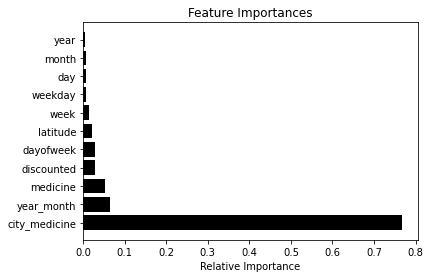

In [32]:
from matplotlib import pyplot as plt
features = X_train.columns
importances = xgb.feature_importances_
indices = np.argsort(importances)[::-1] # np.argsort returns the indices that would sort an array.
pd.DataFrame([X_train.columns[indices],np.sort(importances)[::-1]])
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='black')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

In [33]:
xgb.feature_importances_

array([0.00332528, 0.00694665, 0.00703207, 0.05152429, 0.02840906,
       0.06386723, 0.76744765, 0.01497174, 0.02086586, 0.00778371,
       0.02782641], dtype=float32)

So there is not much change in performance in the model,let us extract the footfall data for future models

In [35]:
test=test[['year', 'month', 'day', 'medicine', 'discounted', 'year_month', 'city_medicine', 'week', 'latitude', 'weekday', 'dayofweek']]

In [36]:
test["footfall_perday_permed"]=xgb.predict(test)

Let us make a copy of the merged test data with footfall

##### As data is big, The system  was crashing so built these models using Kaggle and could not do hyperparameter tuning as the kaggle was also crashing

In [37]:
from IPython.display import HTML
import pandas as pd
import numpy as np
import base64
# function that takes in a dataframe and creates a text link to  
# download it (will only work for files < 2MB or so)
def create_download_link(df, title = "Download CSV file", filename = "data.csv"):  
    csv = test.to_csv(index=False)
    b64 = base64.b64encode(csv.encode())
    payload = b64.decode()
    html = '<a download="{filename}" href="data:text/csv;base64,{payload}" target="_blank">{title}</a>'
    html = html.format(payload=payload,title=title,filename=filename)
    return HTML(html)

# create a random sample dataframe
#df = pd.DataFrame(np.random.randn(50, 4), columns=list('ABCD'))

# create a link to download the dataframe
create_download_link(test)